In [1]:

pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 35.1 MB/s eta 0:00:00


In [2]:
#importing libraries required
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from rdkit import Chem
import numpy as np
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectKBest, f_regression


In [3]:
# Load the dataset from the local path
dataset_path = '/content/solubility_data.csv'
data = pd.read_csv(dataset_path)

data.head()


,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


In [4]:
# Access the SMILES column
# Display the SMILES column from the loaded dataset
data.SMILES
print(data.SMILES[0])


ClCC(Cl)(Cl)Cl


In [5]:
# Convert SMILES string to RDKit molecule object

mol = Chem.MolFromSmiles(data.SMILES[0])

test_mol = Chem.MolFromSmiles('ClCC(Cl)(Cl)Cl')
# Get the number of atoms in the molecule
print ( " Number of atoms in ClCC(Cl)(Cl)Cl : ", test_mol.GetNumAtoms())


#  Molecular descriptor calculation - Method 1
mol_list = []

# Convert each SMILES string into a molecule object
for element in data.SMILES:
    mol = Chem.MolFromSmiles(element)
    mol_list.append(mol)
print ("Molecular des. method 1 : " , len(mol_list), mol_list[:5])

# method 2 - Use list comprehension to convert SMILES strings into molecule objects
mol_list2 = [Chem.MolFromSmiles(element) for element in data.SMILES]

# Verify the number of molecules and display the first 5
print ("Molecular des. method 2 : " , len(mol_list2), mol_list2[:5])


 Number of atoms in ClCC(Cl)(Cl)Cl :  6
Molecular des. method 1 :  1144 [<rdkit.Chem.rdchem.Mol object at 0x79bc06335460>, <rdkit.Chem.rdchem.Mol object at 0x79bc06335150>, <rdkit.Chem.rdchem.Mol object at 0x79bc063354d0>, <rdkit.Chem.rdchem.Mol object at 0x79bc06335540>, <rdkit.Chem.rdchem.Mol object at 0x79bc063355b0>]
Molecular des. method 2 :  1144 [<rdkit.Chem.rdchem.Mol object at 0x79bc06388c80>, <rdkit.Chem.rdchem.Mol object at 0x79bc06388cf0>, <rdkit.Chem.rdchem.Mol object at 0x79bc06388d60>, <rdkit.Chem.rdchem.Mol object at 0x79bc06388dd0>, <rdkit.Chem.rdchem.Mol object at 0x79bc06388e40>]


In [6]:
#1 - BASIC DESCRIPTOR GENERATION -
#LogP, Molecular Weight (MW), and Rotatable Bonds (RB) Descriptors

# Function to generate molecular descriptors (LogP, MW, RB)
def generate(smiles, verbose=False):
    moldata = []
    for elem in smiles:
        mol = Chem.MolFromSmiles(elem)
        moldata.append(mol)

    # Initialize an empty array to store descriptor values
    baseData = np.arange(1, 1)
    i = 0
    for mol in moldata:
        # Calculate molecular descriptors
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_MolWt = Descriptors.MolWt(mol)
        desc_NumRotatableBonds = Descriptors.NumRotatableBonds(mol)

        # Store descriptors in a row
        row = np.array([desc_MolLogP, desc_MolWt, desc_NumRotatableBonds])

        # Append to baseData
        if i == 0:
            baseData = row
        else:
            baseData = np.vstack([baseData, row])
        i += 1

    # Define column names for the descriptors
    columnNames = ["MolLogP", "MolWt", "NumRotatableBonds"]

    # Convert to a DataFrame
    descriptors = pd.DataFrame(data=baseData, columns=columnNames)

    return descriptors

# Generate descriptors for all SMILES in the dataset
df = generate(data.SMILES)

# Display the generated descriptors
df.head()


,MolLogP,MolWt,NumRotatableBonds
0,2.5954,167.850,0.0
1,2.3765,133.405,0.0
2,2.5938,167.850,1.0
3,2.0289,133.405,1.0
4,2.9189,187.375,1.0


In [7]:
# Number of Aromatic Atoms for a Single Molecule
# Define a function to calculate the number of aromatic atoms in a molecule
def AromaticAtoms(m):
    aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
    aa_count = sum(1 for i in aromatic_atoms if i)
    return aa_count

m = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
AromaticAtoms(m)
desc_AromaticAtoms = [AromaticAtoms(element) for element in mol_list]
print ( " Number of Aromatic Atoms in COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21 : " , desc_AromaticAtoms[:5])


#  Number of Heavy Atoms for a Single Molecule
m = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
Descriptors.HeavyAtomCount(m)
desc_HeavyAtomCount = [Descriptors.HeavyAtomCount(element) for element in mol_list]
print ( " Number of heavy Atoms in COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21 : " , desc_HeavyAtomCount[:5])


#  Aromatic Proportion (AP) Descriptor for a Single Molecule
m = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
aromatic_proportion = AromaticAtoms(m) / Descriptors.HeavyAtomCount(m)
desc_AromaticProportion = [AromaticAtoms(element) / Descriptors.HeavyAtomCount(element) for element in mol_list]
df_desc_AromaticProportion = pd.DataFrame(desc_AromaticProportion, columns=['AromaticProportion'])
print (" Aromatic Proportion for COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21" , df_desc_AromaticProportion.head())

 Number of Aromatic Atoms in COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21 :  [0, 0, 0, 0, 0]
 Number of heavy Atoms in COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21 :  [6, 5, 6, 5, 8]
 Aromatic Proportion for COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21    AromaticProportion
0                 0.0
1                 0.0
2                 0.0
3                 0.0
4                 0.0


In [8]:
#SNIP 01 - Combine All Descriptors into One DataFrame
# Concatenate the descriptor DataFrames into a single matrix
X = pd.concat([df, df_desc_AromaticProportion], axis=1)

# Display the combined matrix
X.head()


,MolLogP,MolWt,NumRotatableBonds,AromaticProportion
0,2.5954,167.850,0.0,0.0
1,2.3765,133.405,0.0,0.0
2,2.5938,167.850,1.0,0.0
3,2.0289,133.405,1.0,0.0
4,2.9189,187.375,1.0,0.0


In [9]:
#2 EXTRACTION OF TARGET VARIABLE
# Define Y Matrix (Target Variable)
# Extract the target variable (Solubility)
Y = data.iloc[:, 1]

# Display the target variable
Y.head()


,measured log(solubility:mol/L)
0,-2.18
1,-2.00
2,-1.74
3,-1.48
4,-3.04


In [10]:
#3 - Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Initialize the linear regression model
model = linear_model.LinearRegression()


In [11]:
# 4 - Train Model and Evaluate on Training Data
# Fit the model to the training data
model.fit(X_train, Y_train)

# Predict on the training data
Y_pred_train = model.predict(X_train)

# Print the training results
print('TRAIN DATA')
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f' % mean_squared_error(Y_train, Y_pred_train))
print('Coefficient of determination (R^2): %.2f' % r2_score(Y_train, Y_pred_train))


TRAIN DATA
Coefficients: [-0.7354098  -0.00688385 -0.00638097 -0.32169905]
Intercept: 0.27901524155018365
Mean squared error (MSE): 1.02
Coefficient of determination (R^2): 0.76


In [12]:
# 5 -  Evaluate Model on Test Data
# Predict on the test data
Y_pred_test = model.predict(X_test)

# Print the test results
print('TEST DATA')
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f' % mean_squared_error(Y_test, Y_pred_test))
print('Coefficient of determination (R^2): %.2f' % r2_score(Y_test, Y_pred_test))


TEST DATA
Coefficients: [-0.7354098  -0.00688385 -0.00638097 -0.32169905]
Intercept: 0.27901524155018365
Mean squared error (MSE): 1.00
Coefficient of determination (R^2): 0.78


In [13]:
#6 the Linear Regression Equation
print('LogS = %.2f %.2f LogP %.4f MW %.4f RB %.2f AP' %
      (model.intercept_, model.coef_[0], model.coef_[1], model.coef_[2], model.coef_[3]))


LogS = 0.28 -0.74 LogP -0.0069 MW -0.0064 RB -0.32 AP


In [14]:
# 7-   Train Model on Entire Dataset and Compare Results
# Fit the model on the entire dataset
full = linear_model.LinearRegression()
full.fit(X, Y)

# Predict on the full dataset
full_pred = full.predict(X)

# Print the results
print("ENTIRE DATASET")
print('Coefficients:', full.coef_)
print('Intercept:', full.intercept_)
print('Mean squared error (MSE): %.2f' % mean_squared_error(Y, full_pred))
print('Coefficient of determination (R^2): %.2f' % r2_score(Y, full_pred))

# Display the full model equation
full_yintercept = '%.2f' % full.intercept_
full_LogP = '%.2f LogP' % full.coef_[0]
full_MW = '%.4f MW' % full.coef_[1]
full_RB = '+ %.4f RB' % full.coef_[2]
full_AP = '%.2f AP' % full.coef_[3]

print(" Linear Regression Equation: ")

print('LogS = ' + full_yintercept + ' ' + full_LogP + ' ' + full_MW + ' ' + full_RB + ' ' + full_AP)


ENTIRE DATASET
Coefficients: [-0.74173609 -0.00659927  0.00320051 -0.42316387]
Intercept: 0.2565006830997185
Mean squared error (MSE): 1.01
Coefficient of determination (R^2): 0.77
 Linear Regression Equation: 
LogS = 0.26 -0.74 LogP -0.0066 MW + 0.0032 RB -0.42 AP


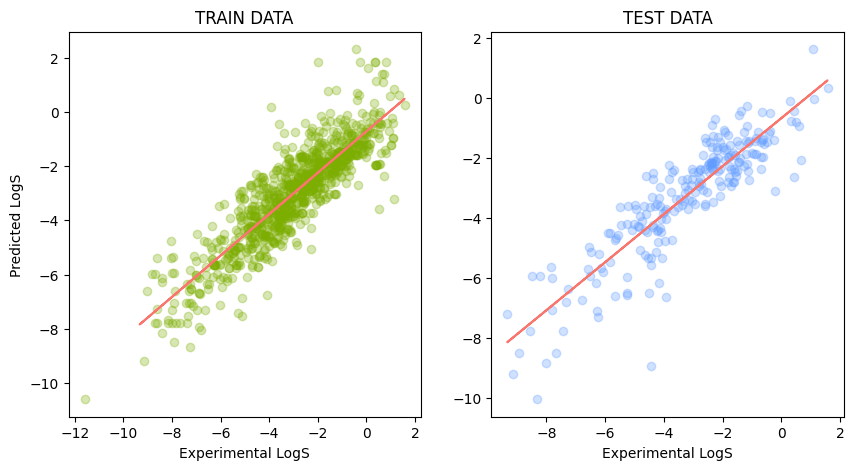

In [15]:
#8 -  Scatter Plot (Horizontal)
# Verify the shape of train and test data
Y_train.shape, Y_pred_train.shape
Y_test.shape, Y_pred_test.shape

# Create a figure for side-by-side plots
plt.figure(figsize=(10,5))

# Plot 1: Train data
plt.subplot(1, 2, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="#7CAE00", alpha=0.3)
z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test, p(Y_test), "#F8766D")
plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')
plt.title("TRAIN DATA")

# Plot 2: Test data
plt.subplot(1, 2, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=0.3)
z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test, p(Y_test), "#F8766D")
plt.xlabel('Experimental LogS')
plt.title("TEST DATA")

# Save the plots
plt.savefig('plot_horizontal_logS.png')
plt.show()


In [16]:
#9 - DROPPING DESCRIPTOR AROMATIC PROPORTION
#Check the columns in df_desc_AromaticProportion
print("Columns in df_desc_AromaticProportion before drop:")
print(df_desc_AromaticProportion.columns)

# Drop AromaticProportion if it exists
if 'AromaticProportion' in df_desc_AromaticProportion.columns:
    df_desc_AromaticProportion = df_desc_AromaticProportion.drop(columns=['AromaticProportion'])
else:
    print("Column 'AromaticProportion' not found in df_desc_AromaticProportion.")

# Concatenate the original dataset with the descriptors
final_df = pd.concat([data, X, df_desc_AromaticProportion], axis=1)

# Save the final dataset to a CSV file
final_df.to_csv('/content/solubility_with_descriptors.csv', index=False)

print("Final dataset saved successfully.")


Columns in df_desc_AromaticProportion before drop:
Index(['AromaticProportion'], dtype='object')
Final dataset saved successfully.


In [17]:
#10 - Initialize RandomForestRegressor and GradientBoostingRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Train Random Forest Model
rf_model.fit(X_train, Y_train)

# Train Gradient Boosting Model
gb_model.fit(X_train, Y_train)


GradientBoostingRegressor(random_state=42)

In [18]:
#11 - Random Forest and gradient boost training
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Generate predictions
Y_pred_rf_train = rf_model.predict(X_train)
Y_pred_rf_test = rf_model.predict(X_test)

Y_pred_gb_train = gb_model.predict(X_train)
Y_pred_gb_test = gb_model.predict(X_test)

# Create a dictionary to store the evaluation metrics
metrics = {
    'Model': ['Random Forest', 'Random Forest', 'Gradient Boosting', 'Gradient Boosting'],
    'Data': ['Train', 'Test', 'Train', 'Test'],
    'MSE': [
        mean_squared_error(Y_train, Y_pred_rf_train),
        mean_squared_error(Y_test, Y_pred_rf_test),
        mean_squared_error(Y_train, Y_pred_gb_train),
        mean_squared_error(Y_test, Y_pred_gb_test)
    ],
    'R^2': [
        r2_score(Y_train, Y_pred_rf_train),
        r2_score(Y_test, Y_pred_rf_test),
        r2_score(Y_train, Y_pred_gb_train),
        r2_score(Y_test, Y_pred_gb_test)
    ]
}

# Convert the dictionary into a DataFrame
metrics_df = pd.DataFrame(metrics)

# Separate the data into two DataFrames: one for training data and one for testing data
train_metrics_df = metrics_df[metrics_df['Data'] == 'Train'].reset_index(drop=True)
test_metrics_df = metrics_df[metrics_df['Data'] == 'Test'].reset_index(drop=True)

# Display both DataFrames without index
print("Training Data Metrics:")
print(train_metrics_df.to_string(index=False))

print("\nTesting Data Metrics:")
print(test_metrics_df.to_string(index=False))


Training Data Metrics:
            Model  Data      MSE      R^2
    Random Forest Train 0.082461 0.980887
Gradient Boosting Train 0.322782 0.925185

Testing Data Metrics:
            Model Data      MSE      R^2
    Random Forest Test 0.702577 0.849325
Gradient Boosting Test 0.709980 0.847737


IMPROVING MODEL PERFORMANCE

In [19]:
# 12 - ADVANCE DESCRIPTOR INCLUSION
# Function to calculate existing descriptors: MolLogP, MolWt, NumRotatableBonds, AromaticProportion
def generate_existing_descriptors(smiles_list):
    moldata = []
    for smile in smiles_list:
        mol = Chem.MolFromSmiles(smile)
        moldata.append(mol)

    baseData = np.arange(1, 1)
    i = 0
    for mol in moldata:
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_MolWt = Descriptors.MolWt(mol)
        desc_NumRotatableBonds = Descriptors.NumRotatableBonds(mol)
        row = np.array([desc_MolLogP, desc_MolWt, desc_NumRotatableBonds])

        if i == 0:
            baseData = row
        else:
            baseData = np.vstack([baseData, row])
        i += 1

    columnNames = ["MolLogP", "MolWt", "NumRotatableBonds"]
    descriptors = pd.DataFrame(data=baseData, columns=columnNames)
    return descriptors

# Function to calculate additional descriptors: HBD, HBA, and TPSA
def calculate_additional_descriptors(smiles_list):
    hbd_list = []
    hba_list = []
    tpsa_list = []

    for smile in smiles_list:
        mol = Chem.MolFromSmiles(smile)
        if mol:
            hbd = Descriptors.NumHDonors(mol)
            hba = Descriptors.NumHAcceptors(mol)
            tpsa = Descriptors.TPSA(mol)
        else:
            hbd = hba = tpsa = None

        hbd_list.append(hbd)
        hba_list.append(hba)
        tpsa_list.append(tpsa)

    return hbd_list, hba_list, tpsa_list

# Function to generate 3D coordinates using RDKit
def generate_3d_coordinates(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        # Generate 3D coordinates using ETKDG
        AllChem.EmbedMolecule(mol, randomSeed=42)
        AllChem.UFFOptimizeMolecule(mol)
        return mol
    else:
        return None

# Function to calculate extra descriptors: Wiener Index and Molecular Volume
def calculate_extra_descriptors(smiles_list):
    wiener_list = []
    vol_list = []  # Now using MolWt as a proxy for volume

    for smile in smiles_list:
        mol = Chem.MolFromSmiles(smile)
        if mol:
            # Manually calculate Wiener Index (sum of shortest path lengths between all atom pairs)
            wiener_index = calculate_wiener_index(mol)

            # Molecular Volume: Using MolWt as a proxy (or another method if available)
            mol_volume = Descriptors.MolWt(mol)  # Use MolWt as a proxy for molecular size

        wiener_list.append(wiener_index)
        vol_list.append(mol_volume)  # Use MolWt as volume approximation

    return wiener_list, vol_list

# Function to calculate Wiener Index manually (sum of shortest path lengths between all atom pairs)
def calculate_wiener_index(mol):
    # Get the atom count and adjacency matrix
    atom_count = mol.GetNumAtoms()
    adjacency_matrix = Chem.rdmolops.GetAdjacencyMatrix(mol)

    # Compute the shortest path lengths (distances between all pairs of atoms)
    dist_matrix = np.zeros((atom_count, atom_count))
    for i in range(atom_count):
        for j in range(i + 1, atom_count):
            dist_matrix[i, j] = dist_matrix[j, i] = Chem.rdmolops.GetDistanceMatrix(mol)[i][j]

    # Wiener index is the sum of distances between all pairs of atoms
    wiener_index = np.sum(dist_matrix) / 2
    return wiener_index

# Generate existing descriptors
existing_descriptors = generate_existing_descriptors(data['SMILES'])

# Generate additional descriptors (HBD, HBA, TPSA)
hbd, hba, tpsa = calculate_additional_descriptors(data['SMILES'])

# Generate extra descriptors (Wiener Index, Mol Volume)
wiener, volume = calculate_extra_descriptors(data['SMILES'])

# Combine the descriptors into the final dataset
final_data = pd.concat([data, existing_descriptors], axis=1)
final_data['HBD'] = hbd
final_data['HBA'] = hba
final_data['TPSA'] = tpsa
final_data['WienerIndex'] = wiener
final_data['MolVolume'] = volume

# Save the final dataset with all descriptors to CSV
final_data.to_csv('/content/solubility_improved_descriptors.csv', index=False)

# Display the first few rows of the updated dataset to verify the changes
final_data.head()


,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES,MolLogP,MolWt,NumRotatableBonds,HBD,HBA,TPSA,WienerIndex,MolVolume
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl,2.5954,167.850,0.0,0,0,0.0,28.0,167.850
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl,2.3765,133.405,0.0,0,0,0.0,16.0,133.405
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl,2.5938,167.850,1.0,0,0,0.0,29.0,167.850
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl,2.0289,133.405,1.0,0,0,0.0,18.0,133.405
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl,2.9189,187.375,1.0,0,0,0.0,58.0,187.375


In [20]:
#13 MODEL TRAINING
import pandas as pd
from sklearn.model_selection import train_test_split

# Example: Load or define the dataset
data_with_descriptors = pd.read_csv('/content/solubility_improved_descriptors.csv')  # Update with actual path

# Define the features (X) and target (y)
X = data_with_descriptors[['MolLogP', 'MolWt', 'NumRotatableBonds', 'HBD', 'HBA', 'TPSA', 'WienerIndex', 'MolVolume']]
y = data_with_descriptors['measured log(solubility:mol/L)']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shape of the train and test sets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(915, 8) (229, 8) (915,) (229,)


In [21]:
# 13 - Ensure the training set is cleaned (e.g., removing NaNs or infinities)
X_train = X_train.fillna(X_train.mean())
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_train_clean = X_train.dropna()

y_train_clean = y_train[X_train_clean.index]

X_test_clean = X_test.fillna(X_test.mean())
X_test_clean = X_test_clean.replace([np.inf, -np.inf], np.nan)
X_test_clean = X_test_clean.dropna()

y_test_clean = y_test[X_test_clean.index]  # Ensure y corresponds to cleaned X


Selected features: Index(['MolLogP', 'MolWt', 'WienerIndex', 'MolVolume'], dtype='object')
Feature Importances:
MolLogP        0.828964
MolWt          0.129672
WienerIndex    0.019871
MolVolume      0.021493
dtype: float64


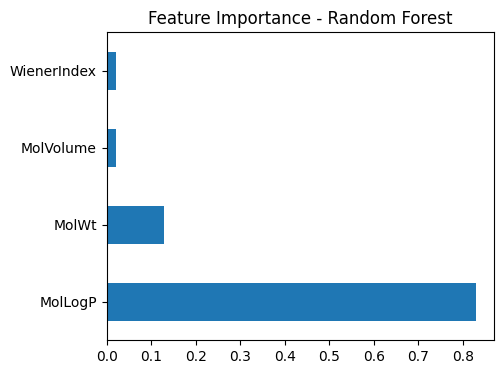

<Figure size 640x480 with 0 Axes>

In [22]:
# 15 - FEATURE SELECTIION & IMPORTANCE
#Define the feature selection method (SelectKBest with f_regression)
selector = SelectKBest(score_func=f_regression, k=4)  # Selecting the top 4 features
selector.fit(X_train_clean, y_train_clean)

# Get the selected features
selected_columns = X_train_clean.columns[selector.get_support()]
print("Selected features:", selected_columns)

# Plot the feature importance using the selected columns
feat_importances = pd.Series(rf_model.feature_importances_, index=selected_columns)

# Print the feature importances
print("Feature Importances:")
print(feat_importances)

# Plot the feature importance
plt.figure(figsize=(5, 4))
feat_importances.nlargest(7).plot(kind='barh')
plt.title('Feature Importance - Random Forest')
plt.show()
plt.savefig('feature_importance_rf.png', bbox_inches='tight', dpi=300)


In [23]:
# 14 - Initialize the models
# Create a dictionary of models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'MLP': MLPRegressor(hidden_layer_sizes=(64,), max_iter=1000, random_state=42)
}

# Initialize the metrics dictionary
metrics = {
    'Training Data Metrics': {},
    'Testing Data Metrics': {}
}

# Loop through the models to train, predict, and calculate metrics
for model_name, model in models.items():
    model.fit(X_train_clean, y_train_clean)

    # Predict on training and testing data
    y_pred_train = model.predict(X_train_clean)
    y_pred_test = model.predict(X_test)

    # Calculate MSE and R^2 for training data
    train_mse = mean_squared_error(y_train_clean, y_pred_train)
    train_r2 = r2_score(y_train_clean, y_pred_train)

    # Calculate MSE and R^2 for testing data
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)

    # Store metrics for the training data
    metrics['Training Data Metrics'][model_name] = {
        'MSE': train_mse,
        'R^2': train_r2
    }

    # Store metrics for the testing data
    metrics['Testing Data Metrics'][model_name] = {
        'MSE': test_mse,
        'R^2': test_r2
    }

# Convert metrics to DataFrames for better visualization
train_metrics_df = pd.DataFrame.from_dict(metrics['Training Data Metrics'], orient='index')
test_metrics_df = pd.DataFrame.from_dict(metrics['Testing Data Metrics'], orient='index')

# Add a 'Data' column for train/test labels
train_metrics_df['Data'] = 'Train'
test_metrics_df['Data'] = 'Test'

# Add 'Model' column as index for both DataFrames
train_metrics_df['Model'] = train_metrics_df.index
test_metrics_df['Model'] = test_metrics_df.index

# Reorganize columns for clarity
train_metrics_df = train_metrics_df[['Model', 'Data', 'MSE', 'R^2']]
test_metrics_df = test_metrics_df[['Model', 'Data', 'MSE', 'R^2']]

# Display the metrics tables
print("Training Data Metrics:")
print(train_metrics_df)

print("\nTesting Data Metrics:")
print(test_metrics_df)


Training Data Metrics:
                               Model   Data       MSE       R^2
Random Forest          Random Forest  Train  0.075768  0.982777
Gradient Boosting  Gradient Boosting  Train  0.287794  0.934582
XGBoost                      XGBoost  Train  0.013042  0.997035
MLP                              MLP  Train  1.161948  0.735881

Testing Data Metrics:
                               Model  Data       MSE       R^2
Random Forest          Random Forest  Test  0.422538  0.902966
Gradient Boosting  Gradient Boosting  Test  0.464383  0.893357
XGBoost                      XGBoost  Test  0.449846  0.896695
MLP                              MLP  Test  1.269809  0.708394


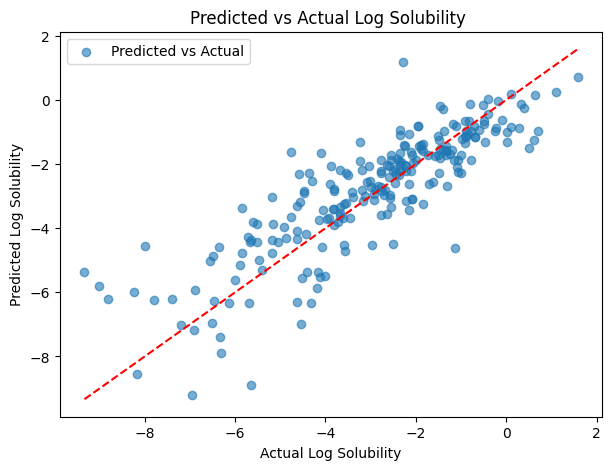

<Figure size 640x480 with 0 Axes>

In [24]:

# 16 - Plot predicted vs actual for data
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred_test, alpha=0.6, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Log Solubility')
plt.ylabel('Predicted Log Solubility')
plt.title('Predicted vs Actual Log Solubility ')
plt.legend()
plt.show()
plt.savefig('predicted_vs_actual_after_improvement.png', bbox_inches='tight', dpi=300)

